# Policy gradients (REINFORCE)

In [1]:
# Import all necessary libraries

import torch
from torch.distributions import Categorical
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gymnasium as gym
from gymnasium.spaces.box import Box
from gymnasium.spaces.discrete import Discrete

## Neural Network

Define a 3 layers neural network using a class named `Policy`. Input atributes are `observation_dim`, `n_actions`, `hidden_layers_dim`.
Use fully connected layers with `Relu` activation functions.

In [2]:
# Neural network to estimate the policy

class Policy(nn.Module):
    def __init__(self, observation_dim, n_actions, hidden_layers_dim, weights_path=None):
        super(Policy, self).__init__()
        ...
        
    def forward(self, obs):
        ...

## PolicyGradient Agent

Implement a class that includes the methods to train the Policy network defined previously. The main methods to implement are:

* initialize the class,
* choose and action,
* compute the discounted future rewards, and
* learn the policy.

### init

Save all the Agent parameters (i.e., `observation_dim`, `n_actions`, `hidden_layers_dim`, `lr`, and `gamma`) and create an attribute named `pi` to store the `Policy` Neural Network and an `Adam` optimizer initialized with the `pi` parameters and `lr` learning rate.


### Choose action

To decide wich action execute you can define two methods:

* `get_policy(obs)`: Passes the `obs` forward to the `pi` policy Neural Network and transforms the received logits into a `Categorical` distribution (see https://pytorch.org/docs/stable/distributions.html).  

* `get_action(obs)`: Obtains a `Categoriacal` distributuion using `get_policy` and returns a sampled action from it.

### Discounted future reward

Takes all the rewards obtained in one episode and generates a tensor were the last position is the value of the last reward, the previous position is the sum of the last reward and the previous reward multiplied by `gamma`, and so on. 
One the discontinued future reward is obtained, normalize it by substracting the mean and dividing by the standard deviation.
Then, return the normalized discounted rewards.

### Learn

The method should receive the discounted rewards, and the log probabilities of the actions taken and compute the the loss of the policy. Then run the optimizer (i.e., `backward` and `step`).

The loss can be computed as 
    $$
    -\frac{1}{n} \sum_{i=0}^{N} \log(\pi(a_i|s_i)) \cdot R_i
    $$


Think where you can save/return the log probabilities of the actions taken and the rewards obtained at each step.

In [3]:
class VanillaPolicyGradient(object):
    def __init__(self, observation_dim, n_actions, hidden_layers_dim, lr=0.001, gamma=0.99, weights_path=None):
        ...
        
    # make function to compute action distribution
    def get_policy(self, obs):
        ...

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(self, obs):
        ...

    def discounted_future_reward(self, rewards):
        ...

    def learn(self, fut_rew, logprob):
        ...

## Training Loop

Implement a training loop that interacts with the environment (i.e., chose the best action and runs a step), stores the rewards and log probabilities of the actions taken, and once the episode finalizes, computes the discounted rewards and trains the policy network with the `learn` method.

You can add a condition to stop the training loop when the mean reward of the last 20 or 50 episodes is greater than a `score_solved` value.

In [4]:
from matplotlib import pyplot as plt
# Main Function 
def training(env, hidden=128, lr=1e-2, num_episodes=1000, gamma=0.99, score_solved=200.0):
    
    assert isinstance(env.observation_space, Box), \
        "This example only works for envs with continuous state spaces."
    assert isinstance(env.action_space, Discrete), \
        "This example only works for envs with discrete action spaces."

    obs_dim = ...
    n_acts = ...
    agent = VanillaPolicyGradient(obs_dim, n_acts, hidden, lr, gamma)
    score_history = []  # for ploting
    rewards = []        # to comopute future rewards and then loss
    logprob = []        # to compute loss
    for i in range(num_episodes):
        # first obs comes from env.reset
        ...
        total_reward = 0
        done = False
        while not done:
            # act in the environment and save logprob, reward and accuumulate total reward for the episode to plot score history
            ...
        # If episode finalizes, store the total reward, and compute the future rewards and learn
        ...

        # Clear log probabilities and rewards for the next episode
        ...

        if (i+1) % 50 == 0:
            print("Episode {}\t\ttotal_reward: {}, average reward {}".format(i, total_reward, np.mean(score_history[-50:])))
        if i > 20 and np.mean(score_history[i-20:i]) > score_solved:
            print("Model learn at iteration {}".format(i))
            break
        
    plt.plot(score_history)
    plt.show()
    return agent, score_history

Try your code solving the `LunarLander-v2` environment from OpenAI gym.

Policy(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
Episode 49		total_reward: 14.780001385653208, average reward -156.5070358673094
Episode 99		total_reward: -7.081967352989096, average reward -87.17127518203637
Episode 149		total_reward: -77.43236129444367, average reward -103.05097059791801
Episode 199		total_reward: 92.1302840970572, average reward -32.801291701591516
Episode 249		total_reward: -55.86105122048363, average reward -51.884122434921174
Episode 299		total_reward: -175.5801991069723, average reward -48.48735531244454
Episode 349		total_reward: -79.89148231505925, average reward -67.70186574295592
Episode 399		total_reward: -28.571841857514155, average reward -24.868532597690038
Episode 449		total_reward: 130.5776576185741, average reward 6.765048421320384
Episode 499		total_reward: -113.289087279722, average reward 51.208152452244356


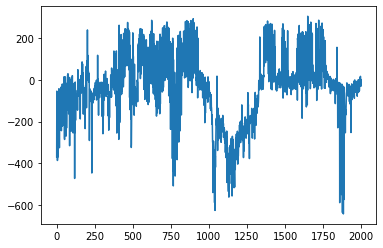

In [5]:
env = gym.make('LunarLander-v2')
agent, score_history = training(env, hidden=128, lr=0.005, num_episodes=2000, gamma=0.99, score_solved=200.0) 

## Using multiple batches

In the previous implementation, you are calling the `learn` method at the end of each episode. This can lead to high variance in the policy gradient and, despite being the easiest way to implement the policy gradient, it is not the way explained in class. In fact, we should compute the gradient of the policy using a batch of episodes.

Modify the previous code to accumulated multiple episodes (i.e., `batch_size=10`) before updating the weights. Be careful that you still have to compute the accumulated discounted rewards for each episode. If you have organized your code correctly, you should only have to modify the training loop.

Repeat the training loop with the new implementation and compare the results.

In [6]:
from matplotlib import pyplot as plt
# Main Function 
def training(env, hidden=128, lr=1e-2, num_episodes=1000, batch_size=10, gamma=0.99, score_solved=200.0, weights_path=None):
    ...

Policy(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


Episode 49		total_reward: -74.7694192898631, average reward -183.5607732205872
Episode 99		total_reward: -188.94911553577464, average reward -145.84383178284054
Episode 149		total_reward: -68.38949976716347, average reward -96.53693287846524
Episode 199		total_reward: -28.496227430321042, average reward -86.25837584415335
Episode 249		total_reward: -204.19664795519066, average reward -171.94625841321576
Episode 299		total_reward: -299.6086224361253, average reward -173.7965594283816
Episode 349		total_reward: -28.90021663616878, average reward -116.116492956585
Episode 399		total_reward: -201.2879300297367, average reward -63.12710802724483
Episode 449		total_reward: 31.592967507152935, average reward -86.32450015680513
Episode 499		total_reward: 55.94227502701032, average reward -29.004291431418682
Episode 549		total_reward: -21.204550571959743, average reward -0.12835748027521846
Episode 599		total_reward: -131.38306617746554, average reward -24.167027910161167
Episode 649		total_rew

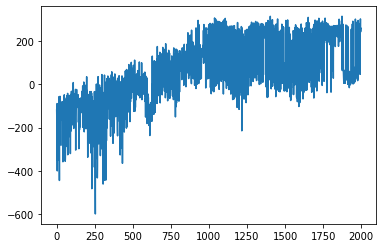

In [7]:
env = gym.make('LunarLander-v2')
agent, score_history = training(env, hidden=128, lr=0.005, num_episodes=2000, batch_size=10, gamma=0.99, score_solved=200.0) 

## Adding a Baseline

We have seen that the policy gradient has high variance. One way to reduce it is to use a baseline. The baseline can be any function that helps to reduce the variance of the policy gradient. In this case, we will use a Neural Network to estimate the \(V(s)\) function.


### Value Network

Create first a new class named `ValueNetwork` that will be a simple Neural Network with 3 layers and `Relu` activation functions. The input of the network will be the observation and the output will be the value of the state.

In [8]:
class ValueNetwork(nn.Module):
    def __init__(self, observation_dim, hidden_layers):
        ...
    
    def forward(self, obs):
        ...

### Baseline PolicyGradient Agent

Modify the previous `PolicyGradient` class to include the `ValueNetwork` and the baseline in the training loop. The main changes are:

* **init**: Create a `ValueNetwork` object and an `Adam` optimizer for the value network with a learning rate `lr_v`. Save the `baseline` attribute to store the value network.

* **update value network**: To update the value function, compute the loss of the value network as the mean squared error between the discounted rewards and the value network output. Once done, run the optimizer for the value network.

$$\sum_{i=0}^{N} (V(s_i) - R_i)^2$$

* **Learn**: Compute the loss of the value network (i.e., call the `update_value_function` method) and then compute the loss of the policy as the mean of the advantage times the log probabilities of the actions taken. Run the optimizer for the policy network.
 
    $$
    -\frac{1}{n} \sum_{i=0}^{N} \log(\pi(a_i|s_i)) \cdot (R_i - V(s_i))
    $$

In [9]:
class VanillaPolicyGradient(object):
    def __init__(self, observation_dim, n_action, hidden_layers, lr=0.001, gamma=0.99, weights_path=None):
        ...
        
    # make function to compute action distribution
    def get_policy(self, obs):
        ...

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(self, obs):
        ...

    def discounted_future_reward(self, rewards):
        ...
    
    def update_value_function(self, states, returns):
        # Train value network to predict returns as the baseline V(s)
        ...
      
    def learn(self, fut_rew, logprob, states):
        ...

Modify the training loop to save the `observations` and pass them to the learning method to optimize the Value Function neural network. The rest of the code should be identical.

In [10]:
from matplotlib import pyplot as plt
# Main Function 
def training(env, hidden=128, lr=1e-2, num_episodes=1000, batch_size=10, gamma=0.99, score_solved=200.0, weights_path=None):
   ...

Policy(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


Episode 49		total_reward: -124.3648620458279, average reward -196.41852538375292
Episode 99		total_reward: -244.54814477803188, average reward -173.7538477633724
Episode 149		total_reward: -94.49967833844897, average reward -384.896489344546
Episode 199		total_reward: -113.52323061297827, average reward -262.7851982806638
Episode 249		total_reward: -85.5871032967083, average reward -119.61350890343336
Episode 299		total_reward: -50.02133593242645, average reward -67.8844284821759
Episode 349		total_reward: -56.546763096813606, average reward -49.58805960528417
Episode 399		total_reward: 7.937367876673075, average reward -59.19691905947955
Episode 449		total_reward: -108.30881784563749, average reward -34.91943495394698
Episode 499		total_reward: 6.884245374303617, average reward -6.5865731893203705
Episode 549		total_reward: -228.5832325192643, average reward -15.959102596723096
Episode 599		total_reward: -15.353392705170506, average reward -3.382011748319265
Episode 649		total_reward:

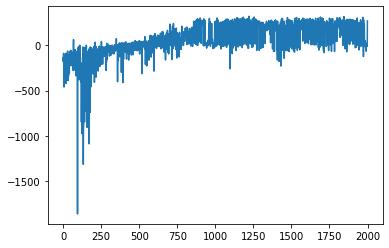

In [11]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
agent, score_history = training(env, hidden=128, lr=0.005, num_episodes=2000, batch_size=10, gamma=0.99, score_solved=200.0)